# Rare Variant Analysis

In this notebook, I'm going to analyze the rare variants identified
in the Rare Variant Processing notebook.

In [1]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [5]:
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'rare_variants.pickle')
rare_vars = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'rare_variant_genotypes.tsv')
rare_var_genotypes = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 
                  'rare_variant_processing', 'tf_disruption.tsv')
tf_disruption = pd.read_table(fn, index_col=0)

In [6]:
t = pd.DataFrame({'position':tf_disruption[tf_disruption.sum(axis=1) > 0].index,
                  'tf_disrupt':True})
rare_vars = rare_vars.merge(t, how='outer')
rare_vars.ix[rare_vars.tf_disrupt.isnull(), 'tf_disrupt'] = False
rare_vars.index = rare_vars.position

In [7]:
unrelateds = list(rna_meta_eqtl.ix[rna_meta_eqtl.in_unrelateds, 'wgs_id'])
log_tpm = np.log10(tpm + 1)

In [8]:
# Create expression and genotype dataframes for unrelated individuals.
rare_var_genotypes_f = rare_var_genotypes[unrelateds]
log_tpm_f = log_tpm[rna_meta[rna_meta.in_unrelateds].index]
log_tpm_f.columns = rna_meta.ix[rna_meta.in_unrelateds, 'wgs_id']
log_tpm_f = log_tpm_f[(log_tpm_f > np.log10(2)).sum(axis=1) >= 10]
log_tpm_c = (log_tpm_f.T - log_tpm_f.mean(axis=1)).T
log_tpm_z = (log_tpm_c.T / log_tpm_c.std(axis=1)).T
ase_pval_f = ase_pval[rna_meta[rna_meta.in_unrelateds].index]
ase_pval_f.columns = rna_meta[rna_meta.in_unrelateds].wgs_id

This next step takes a few minutes to run.

In [9]:
rare_ind = []
rare = {}
for k in ['zscore', 'sample', 'position', 'tf_disrupt', 'ase_pval']:
    rare[k] = []
not_rare_ind = []
not_rare = {}
for k in ['zscore', 'sample', 'position', 'ase_pval']:
    not_rare[k] = []

for i,ind in enumerate(rare_vars.index):
    if i % 1000 == 0:
        print(i)
    se = rare_var_genotypes_f.ix[ind]
    rare_samples = se[se != 0].index
    not_rare_samples = se[se == 0].index
    genes = rare_vars.ix[ind, 'genes']
    for g in genes:
        if g in log_tpm_z.index:
            rare['zscore'] += list(log_tpm_z.ix[g, rare_samples])
            rare['sample'] += list(rare_samples)
            rare['position'] += [ind for i in range(len(rare_samples))]
            rare['tf_disrupt'] += [rare_vars.ix[ind, 'tf_disrupt'] for i in range(len(rare_samples))]
            if g in ase_pval_f.index:
                rare['ase_pval'] += list(ase_pval_f.ix[g, rare_samples])
            else:
                rare['ase_pval'] += [np.nan for i in range(len(rare_samples))]
            rare_ind += ['{}:{}'.format(ind, x) for x in rare_samples]
            
            not_rare['zscore'] += list(log_tpm_z.ix[g, not_rare_samples])
            not_rare['sample'] += list(not_rare_samples)
            not_rare['position'] += [ind for i in range(len(not_rare_samples))]
            if g in ase_pval_f.index:
                not_rare['ase_pval'] += list(ase_pval_f.ix[g, not_rare_samples])
            else:
                not_rare['ase_pval'] += [np.nan for i in range(len(not_rare_samples))]
            not_rare_ind += ['{}:{}'.format(ind, x) for x in not_rare_samples]
rare_info = pd.DataFrame(rare, index=rare_ind)
not_rare_info = pd.DataFrame(not_rare, index=not_rare_ind)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000


In [10]:
r = sum(rare_info.ase_pval.dropna() < 0.005) / float(rare_info.ase_pval.dropna().shape[0])
nr = sum(not_rare_info.ase_pval.dropna() < 0.005) / float(not_rare_info.ase_pval.dropna().shape[0])
a = (rare_info.ase_pval.dropna() < 0.005).value_counts()
b = (not_rare_info.ase_pval.dropna() < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare promoter DHS variant have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare promoter DHS variant have ASE 3.29% of the time while gene/samples without rare promoter DHS variant have ASE 2.85% of the time (odds=1.16, p=6.55e-06, Fisher exact).


Gene/sample pairs with a rare DHS promoter variant are enriched for ASE.

In [11]:
s,p = stats.mannwhitneyu(rare_info.zscore, not_rare_info.zscore)
print('The distributions of z-score expression values for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=3.86e-83).


In [12]:
s,p = stats.mannwhitneyu(rare_info.zscore.abs(), not_rare_info.zscore.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=1.64e-63).


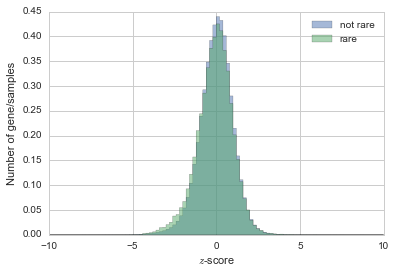

In [13]:
not_rare_info.zscore.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), 
                          alpha=0.5, histtype='stepfilled', label='not rare')
rare_info.zscore.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), 
                      alpha=0.5, histtype='stepfilled', label='rare')
plt.legend()
plt.xlabel('$z$-score')
plt.ylabel('Number of gene/samples');

In [14]:
pdfs = pd.DataFrame(index=np.arange(-10, 10.1, 0.1))
density = scipy.stats.gaussian_kde(rare_info.zscore)
pdfs['rare'] = density(pdfs.index)
density = scipy.stats.gaussian_kde(not_rare_info.zscore)
pdfs['not_rare'] = density(pdfs.index)

In [15]:
density = scipy.stats.gaussian_kde(rare_info[rare_info.tf_disrupt].zscore)
pdfs['rare_tf_disrupt'] = density(pdfs.index)
density = scipy.stats.gaussian_kde(rare_info[rare_info.tf_disrupt == False].zscore)
pdfs['rare_not_tf_disrupt'] = density(pdfs.index)

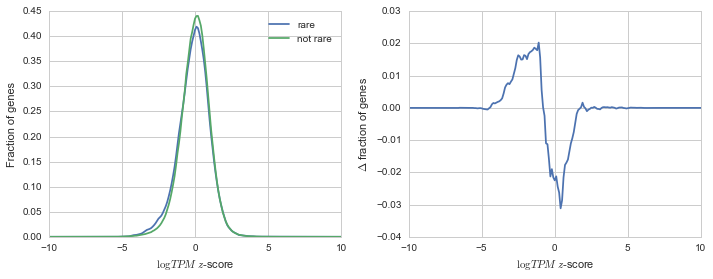

In [16]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

pdfs.rare.plot(label='rare', ax=ax)
pdfs.not_rare.plot(label='not rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax = axs[1]
(pdfs.rare - pdfs.not_rare).plot(ax=ax)
ax.set_ylabel('$\Delta$ fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_var_effect.pdf'))

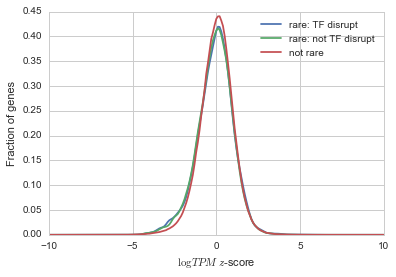

In [17]:
pdfs.rare_tf_disrupt.plot(label='rare: TF disrupt')
pdfs.rare_not_tf_disrupt.plot(label='rare: not TF disrupt')
pdfs.not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

TODO: Estimate effect size, or estimate FDR (for instance, at z=-3, rare variants are functional
with FDR 20%).

In [18]:
cdfs = pd.DataFrame(index=pdfs.index)
area = [0]
for i in range(1, cdfs.shape[0]):
    area.append(0.5 * (pdfs['rare'].loc[pdfs.index[i - 1]] + pdfs['rare'][pdfs.index[i]]) * 0.1)
cdfs['rare'] = pd.Series(area, index=cdfs.index).cumsum()
area = [0]
for i in range(1, cdfs.shape[0]):
    area.append(0.5 * (pdfs['not_rare'].loc[pdfs.index[i - 1]] + pdfs['not_rare'][pdfs.index[i]]) * 0.1)
cdfs['not_rare'] = pd.Series(area, index=cdfs.index).cumsum()

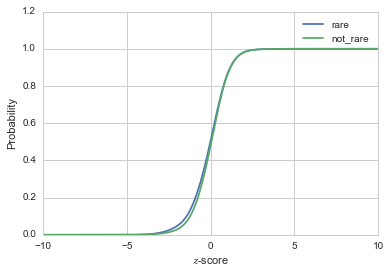

In [19]:
cdfs.plot()
plt.xlabel('$z$-score')
plt.ylabel('Probability');

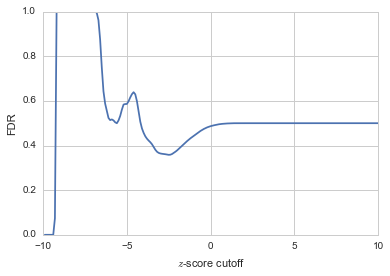

In [20]:
fdr = cdfs.not_rare / (cdfs.sum(axis=1))
fdr.plot()
plt.ylabel('FDR')
plt.xlabel('$z$-score cutoff');

In [21]:
m = se[se > 0.2].min()
i = se[se == m].index[0]
print('The minimum FDR occurs at z={} and is {:.1f}%.'.format(i, m * 100))

The minimum FDR occurs at z=4c3357d4-6638-4de5-aeee-797a2614814c and is 100.0%.


In [22]:
rare_info[rare_info.zscore <= -2.5].shape

(1706, 5)

In [42]:
print(sum(tf_rare_ase_pval < 0.005) / float(tf_rare_ase_pval.shape[0]))
print(sum(not_tf_rare_ase_pval < 0.005) / float(not_tf_rare_ase_pval.shape[0]))

0.0342326003174
0.0282898456679


In [43]:
[[a[True], a[False]], [b[True], b[False]]]

[[1087, 31697], [91917, 3136622]]

In [44]:
a = (tf_rare_ase_pval < 0.005).value_counts()
b = (not_tf_rare_ase_pval < 0.005).value_counts()
stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])

(1.2175127308518565, 0.001118541626587175)

In [45]:
stats.mannwhitneyu(rare, tf_rare)

MannwhitneyuResult(statistic=745230261.0, pvalue=0.24648715857328146)

In [46]:
stats.mannwhitneyu(rare.abs(), tf_rare.abs())

MannwhitneyuResult(statistic=743983155.0, pvalue=0.14771315703930044)

In [47]:
stats.mannwhitneyu(tf_rare, not_tf_rare)

MannwhitneyuResult(statistic=20991202007.5, pvalue=1.0861693777795592e-26)

In [48]:
stats.mannwhitneyu(tf_rare.abs(), not_tf_rare.abs())

MannwhitneyuResult(statistic=20967195077.5, pvalue=6.1988492896309064e-28)

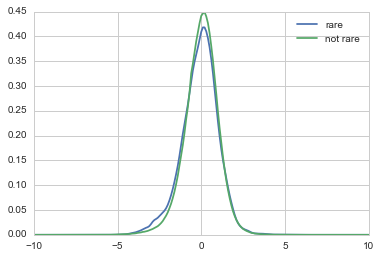

In [49]:
xs = np.arange(-10, 10.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_tf_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

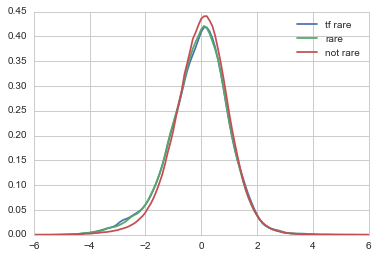

In [50]:
xs = np.arange(-6, 6.1, 0.1)
density = scipy.stats.gaussian_kde(tf_rare)
y_tf_rare = density(xs)
density = scipy.stats.gaussian_kde(rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(not_rare)
y_not_rare = density(xs)
y_tf_rare = pd.Series(y_tf_rare, index=xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_tf_rare.plot(label='tf rare')
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()

## Rare CNVs

In [ ]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/cnv_genotypes.tsv')
cnv_geno = pd.read_table(fn, index_col=0)

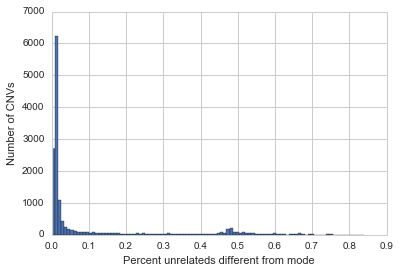

In [ ]:
cnv_info.unrelated_percent_diff_from_mode.hist(bins=100)
plt.ylabel('Number of CNVs')
plt.xlabel('Percent unrelateds different from mode');

In [ ]:
cnv_info.sort_values(by='unrelated_diff_from_mode', inplace=True)

In [ ]:
rare_cnv_info = cnv_info[cnv_info.unrelated_diff_from_mode == 1]
rare_cnv_info = rare_cnv_info.dropna(subset=['gene_overlaps'])

In [ ]:
lessr = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    if sum(se < mode) > 0:
        lessr.append(se[se < mode])
rare_cnv_less = pd.DataFrame(lessr)
rare_cnv_less.to_csv(os.path.join(private_outdir, 'rare_cnv_less.tsv'), sep='\t')

In [ ]:
cnv_rare = []
cnv_rare_ase_pval = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
cnv_not_rare_ase_pval = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        cnv_rare += list(log_tpm_z.ix[g, r])
        cnv_rare_less += list(log_tpm_z.ix[g, lessr])
        cnv_rare_greater += list(log_tpm_z.ix[g, greaterr])
        cnv_not_rare += list(log_tpm_z.ix[g, nr])
        if g in ase_pval.index:
            cnv_rare_ase_pval += list(ase_pval_f.ix[g, r])
            cnv_not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
cnv_rare = pd.Series(cnv_rare)
cnv_rare_ase_pval = pd.Series(cnv_rare_ase_pval).dropna()
cnv_not_rare = pd.Series(cnv_not_rare)
cnv_rare_less = pd.Series(cnv_rare_less)
cnv_rare_greater = pd.Series(cnv_rare_greater)
cnv_not_rare_ase_pval = pd.Series(cnv_not_rare_ase_pval).dropna()

In [ ]:
r = sum(cnv_rare_ase_pval < 0.005) / float(cnv_rare_ase_pval.shape[0])
nr = sum(cnv_not_rare_ase_pval < 0.005) / float(cnv_not_rare_ase_pval.shape[0])
a = (cnv_rare_ase_pval < 0.005).value_counts()
b = (cnv_not_rare_ase_pval < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare genic CNV have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare genic CNV have ASE 8.04% of the time while gene/samples without rare promoter DHS variant have ASE 3.12% of the time (odds=2.72, p=9.73e-13, Fisher exact).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare, cnv_not_rare)
print('The distributions of z-score expression values for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=8.41e-08).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare.abs(), cnv_not_rare.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=1.56e-18).


In [ ]:
print(stats.mannwhitneyu(cnv_rare_less, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_less.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=244274758.0, pvalue=0.26920546044906934)
MannwhitneyuResult(statistic=195411157.0, pvalue=8.539737391520741e-53)


In [ ]:
print(stats.mannwhitneyu(cnv_rare_greater, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_greater.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=48318389.0, pvalue=3.2154123707138734e-22)
MannwhitneyuResult(statistic=52732573.0, pvalue=9.762408868882238e-13)


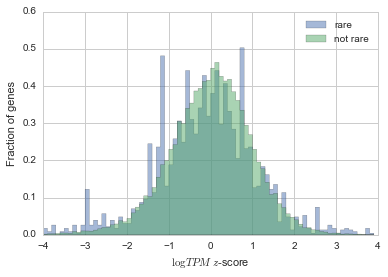

In [ ]:
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

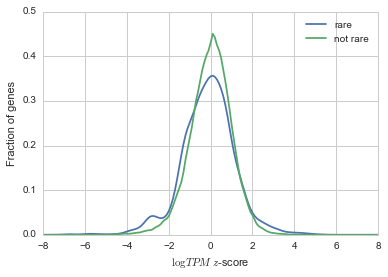

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

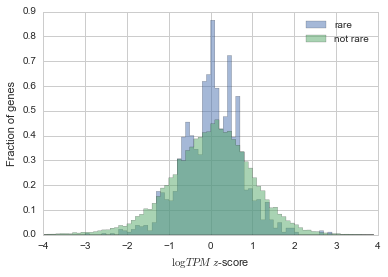

In [ ]:
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

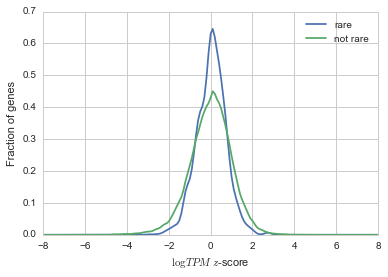

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_less)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

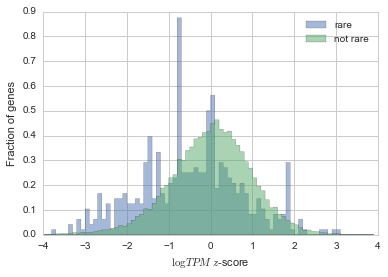

In [ ]:
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

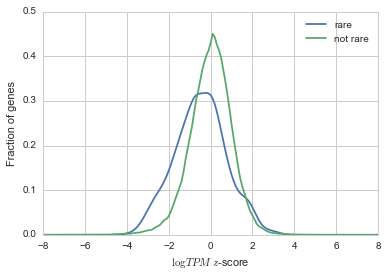

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_greater)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

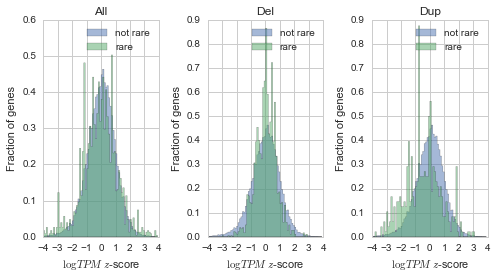

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(7, 4))
ax = axs[0]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('All')

ax = axs[1]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score');
ax.set_title('Del')

ax = axs[2]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('Dup')

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_cnv_hists.pdf'))

In [ ]:
cnv_rare = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        if greaterr.shape[0] > 0:
            if sum(log_tpm_z.ix[g, greaterr] < -2) > 0:
                print(i, g, greaterr)

('CNV_8_146276675_146279317', 'ENSG00000182307.8', f4b0146d-7508-457f-a754-bb4042583c4b    3
Name: CNV_8_146276675_146279317, dtype: int64)
('CNV_9_36273428_36278602', 'ENSG00000122705.12', 7e46a561-21f6-4340-b2e2-41ef50b7d943    3
Name: CNV_9_36273428_36278602, dtype: int64)
('CNV_7_148820780_148825437', 'ENSG00000197024.4', d5034b1e-43c1-486a-8d18-18b15f635e70    3
Name: CNV_7_148820780_148825437, dtype: int64)
('CNV_7_133582402_133604451', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133582402_133604451, dtype: int64)
('CNV_7_133552783_133574111', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133552783_133574111, dtype: int64)
('CNV_7_133526828_133552782', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133526828_133552782, dtype: int64)
('CNV_7_133472945_133511987', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133472945_133511987, dtype: int64)
('CNV_7_133425056_1

In [ ]:
gene_info.ix['ENSG00000122705.12']

gene_name                CLTA
gene_type      protein_coding
chrom                    chr9
start                36190852
end                  36304778
strand                      +
gene_status             KNOWN
source                 HAVANA
level                       1
Name: ENSG00000122705.12, dtype: object

In [ ]:
cnv_rare_greater.head()

AttributeError: 'list' object has no attribute 'head'

In [ ]:
tt = log_tpm_z.apply(lambda x: stats.mstats.normaltest(x)[1], axis=1)

In [ ]:
tt.hist()

In [ ]:
?fisher_exact